### Performance Evaluation ###

In [58]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torchvision import ops

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [59]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey', offset_xy=(0, 0)):
    offset_xy = (10 + offset_xy[0], 100 + offset_xy[1])
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

def detr_detect(detr_model, detr_processor, image, threshold):
    """ Predicts bounding boxes in xywh format """
    assert len(im.shape) == 3, 'Need RGB image as input'
    x_lim, y_lim = (0, image.shape[1]), (0, image.shape[0])
    im_input = processor(im, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**im_input)
    output = processor.post_process_object_detection(model_output, 
                                                     target_sizes=torch.tensor([image.shape[:2]]),
                                                     threshold=threshold)
    output_boxes = output[0].get('boxes').cpu().numpy()
    if len(output_boxes) > 0:
        bboxes = [clipxywh(xyxy2xywh(list(box)), xlim=x_lim, ylim=y_lim, decimals=0) for box in output_boxes]
        areas = [int(box[2]*box[3]) for box in bboxes]
        categories = list(output[0].get('labels').cpu().numpy())
        scores = output[0].get('scores').cpu().numpy()
        categories = [int(c) for c in categories]
        scores = [np.around(s, decimals=4) for s in scores]
        predictions = {'bboxes': bboxes, 'areas': areas, 'categories': categories, 'scores': scores}
    else:
        logger.warning(f'No predictions at threshold {threshold}.')
        predictions = None
    return predictions

### Test data ###

In [23]:
# HSDM DATA
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_240921')
df_file_name = 'objectdata_240921_clean_ide.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file
0,457fecca_20180208_00.png,20,0.565375,"[0.0, 453.28, 267.08, 865.22]",457fecca,Maria,2,2,2,3,2,0,stable,yes,box_457fecca_20180208_00_00.png
1,8fb6f1a1_20220322_00.png,3,0.989590,"[0.0, 69.95, 501.94, 892.3]",8fb6f1a1,Maria,3,2,3,3,2,3,healthy,yes,box_8fb6f1a1_20220322_00_02.png


In [17]:
# Dentex testing data
image_dir = os.path.join(os.environ.get('DATA'), 'dentex_detection_250928', 'test')
df_file_name = 'train_quadrant_enumeration_test_set.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
df = df.loc[(df['dset'] == 'test') & (df['transformation'] == 2)]
display(df.head(2))

file_col = 'file_name'
pos_col = 'ada'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
11230,"[589, 0, 45, 306]",1.0,8.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test
11231,"[527, 0, 91, 306]",1.0,7.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test


In [18]:
# Roboflow test data
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_roboflow_240930')
df_file_name = 'roboflow_240930.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))
# What are the categories in this data set
print(list(df['category'].unique()))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

# Let's get rid of the rows that do not have locations
df = df.loc[~df[pos_col].isnull()]

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)
print(f'Using {len(checked)} images from the Roboflow data set')
print(f'Annotations: {df.shape[0]}')

,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
0,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[381.0, 242.0, 481.474, 279.948]",composite,composite,NaN,40762886f4_0
1,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[8.0, 0.0, 130.293, 176.736]",tooth 23,teeth,11.0,40762886f4_1


['composite', 'tooth 23', 'tooth 25', 'tooth 26', 'tooth 27', 'tooth 33', 'tooth 34', 'tooth 35', 'tooth 36', 'tooth 37', 'tooth 17', 'tooth 16', 'tooth 15', 'tooth 46', 'tooth 47', 'caries', 'tooth 24', 'Calculus', 'root filling', 'crown', 'tooth 45', 'tooth 44', 'tooth 14', 'tooth 18', 'tooth 48', 'tooth 13', 'tooth 43', 'tooth 28', 'tooth 38', 'tooth 12', 'amalgam', 'implant', 'tooth 22', 'periapical pathology', 'tooth 32']
Using 991 images from the Roboflow data set
Annotations: 8788


### Model and image processor ###

In [19]:
model_name = 'rtdetr_251001_02'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

checkpoint_name = 'checkpoint-17500'
checkpoint = os.path.join(model_dir, checkpoint_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())

# Category ID to label conversion
id2label = model_parameters.get('id2label')
id2label = {int(k): int(v) for k,v in id2label.items()}

# Load the image processor
processor = RTDetrImageProcessor.from_pretrained(checkpoint)
# Load the model
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint).to(device)

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

### Predict on an image ###

True: [29, 31]
Pred: [29, 28, 30, 31, 32]


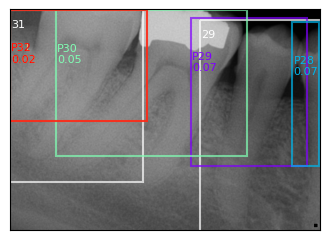

In [55]:
figsize = (4, 4)
threshold = 0.02
idx = 13
file_name = file_name_list[idx]
    
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
df_file = df.loc[df[file_col] == file_name]
bbox_list = df_file[bbox_col].tolist()
pos_list = df_file[pos_col].tolist()
im_width, im_height = im.shape[1], im.shape[0]
x_lim, y_lim = (0, im_width), (0, im_height)
    
# Predict positions
output = detr_detect(detr_model=model, detr_processor=processor, image=im, threshold=threshold)
if output is not None:
    output_bbox_list = output.get('bboxes')
    output_cat_list = output.get('categories')
    output_pos_list = [id2label.get(cat) for cat in output_cat_list]
    score_list = output.get('scores')
    output_label_list = [f'P{p}\n{s:.2f}' for p, s in zip(output_pos_list, score_list)]

    print(f'True: {pos_list}')
    print(f'Pred: {output_pos_list}')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
    ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_label_list, ax=ax, offset_xy=(0, 200))
    plt.show()

In [106]:
# Performance evaluations
threshold = 0.02
min_iou = 0.5
# Ground truth
true_labels = df_file[pos_col].tolist()
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]

# Predictions
output = detr_detect(detr_model=model, detr_processor=processor, image=im, threshold=threshold)
pred_labels = [int(id2label.get(cat)) for cat in output.get('categories')]
pred_bboxes = output.get('bboxes')
pred_scores = output.get('scores')

# We want to classify the predictions
p = 0
# What is the label for this prediction?
p_label = pred_labels[p]
print(p_label)
# Do we have this label in the ground truth?
if p_label in true_labels:
    # The predicted label is in the image
    t = true_labels.index(p_label)
    t_bbox = true_bboxes[t]
    p_bbox = pred_bboxes[p]
    # Calculate the iou
    p_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
    # Is the iou above the IoU threshold?
    if p_iou >= min_iou:
        prediction = 'TP'
    else:
        prediction = 'FP'
else:
    # The predicted label has no ground truth
    # Here, we don't know if it is not in the image, when the ground truth data is incompletely labeled
    p_iou = 0
    prediction = 'FP'

29


In [105]:
print(p_iou)

0.5836030840873718


In [97]:
print(t)

0


In [94]:
display(df_file)

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file
88,0063ddfd_20210226_08.png,29,0.926409,"[734.3099975585938, 38.959999084472656, 1160.3...",0063ddfd,Jennifer,4,2,3,5,4,5,unstable,yes,box_0063ddfd_20210226_08_02.png
89,0063ddfd_20210226_08.png,31,0.934511,"[0.0, 0.0, 516.16, 668.04]",0063ddfd,Michael,4,3,4,5,4,5,unstable,yes,box_0063ddfd_20210226_08_01.png


In [93]:
print(true_labels)

[29, 31]


In [90]:
print(pred_labels)
print(pred_bboxes)
print(pred_scores)

[29, 28, 30, 31, 32]
[[700, 32, 448, 573], [1092, 48, 105, 556], [177, 1, 740, 567], [0, 0, 529, 432], [0, 0, 529, 432]]
[0.0695, 0.0683, 0.0506, 0.0225, 0.0203]


[734, 38, 466, 816]
29
[700, 32, 448, 573]


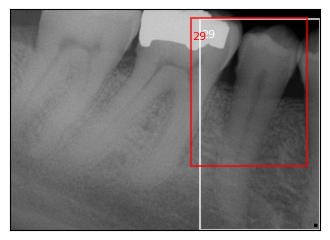

0.5836030840873718


In [99]:
# Let's pick one ground truth and one predicted position
true_pos = 29
true_bbx = list(bbox_list[pos_list.index(true_pos)])
true_bbx = clipxywh(true_bbx, xlim=x_lim, ylim=y_lim, decimals=0)
print(true_bbx)

pred_pos_idx = output_pos_list.index(true_pos)
pred_pos = output_pos_list[pred_pos_idx]
print(pred_pos)
pred_bbx = output_bbox_list[pred_pos_idx]
print(pred_bbx)

# Plot this situation
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=[true_bbx], label_list=[true_pos], ax=ax, color='w')
ax = plot_boxes(image=im, box_list=[pred_bbx], label_list=[pred_pos], ax=ax, color='r', offset_xy=(0, 20))
plt.show()

# Calculate the IoU for the predicted bounding box and the ground truth
iou = DetectionMetrics.compute_iou(bbox_1=true_bbx, bbox_2=pred_bbx, bbox_format='xywh', method='pt')
print(iou)

Basic Terms:

When the model correctly detects an object: TP

When an object not actually in the image is found: FP

When an object in the ground truth is not detected: FN